**Model Evaluation**

We evaluated multiple transformer-based models on both **Kazakh** and **English** test sets to assess their effectiveness in **extrinsic plagiarism detection**. The tested models include:

- **Kazakh**: XLM-RoBERTa (Large/Base), DistilBERT, MiniLM, SBERT, KazakhBERTmulti  
- **English**: XLM-RoBERTa (Large/Base), DistilBERT, MiniLM, SBERT

Each model receives suspicious and source text pairs, then predicts whether the pair is plagiarized (`label=1`) or not (`label=0`). We compute **accuracy**, **precision**, **recall**, and **F1-score** for a comprehensive performance view.

In [1]:
from google.colab import drive
# Mount Google Drive
googledrive = "/content/drive"
drive.mount(googledrive)

Mounted at /content/drive


In [4]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from IPython.display import display
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm

# Define Paths for All Trained Models
models = {
    "kz_XLM_Roberta_Large": "/content/drive/MyDrive/updating-pan-xml-files/kazakh-xlm-roberta-large-v2",
    "kz_XLM_Roberta_Base": "/content/drive/MyDrive/updating-pan-xml-files/kazakh-roberta-base-120K",
    "kz_DistilBERT": "/content/drive/MyDrive/updating-pan-xml-files/DistilBERT-en-kz-full",
    "kz_MiniLM": "/content/drive/MyDrive/updating-pan-xml-files/MiniLM-en-kz-240K",
    "kz_SBERT": "/content/drive/MyDrive/updating-pan-xml-files/sentence-transformers_all-mpnet-base-v2-60K-paragraphs",
    "kz_BERTMulti": "/content/drive/MyDrive/updating-pan-xml-files/KazakhBERTmulti-60K-T4",
    "en_XLM_Roberta_Large": "/content/drive/MyDrive/updating-pan-xml-files/kz-en-xlm-roberta-large-240K",
    "en_XLM_Roberta_Base": "/content/drive/MyDrive/updating-pan-xml-files/english-xlm-roberta-60K-paragraphs",
    "en_DistilBERT": "/content/drive/MyDrive/updating-pan-xml-files/DistilBERT-en-kz-full",
    "en_MiniLM": "/content/drive/MyDrive/updating-pan-xml-files/MiniLM-en-kz-240K",
    "en_SBERT": "/content/drive/MyDrive/updating-pan-xml-files/sentence-transformers_all-mpnet-base-v2-en-60K-paragraphs",
}

# Define Test Datasets
datasets = {
    "kazakh": "/content/drive/MyDrive/updating-pan-xml-files/kz-3950-sentences-for-testing1.csv",
    "english": "/content/drive/MyDrive/updating-pan-xml-files/en-4500-sentences-for-testing6.csv",
}

# Load Dataset
def load_dataset(dataset_path):
    return pd.read_csv(dataset_path)

# Evaluation function for classification models
def evaluate_model(model_path, dataset_path, device, batch_size=32):
    df = load_dataset(dataset_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path).to(device)
    model.eval()

    actual_labels = df["label"].tolist()
    predicted_labels = []

    sentences = [
        f"{row['source_text']} {tokenizer.sep_token} {row['suspicious_text']}"
        for _, row in df.iterrows()
    ]

    for i in tqdm(range(0, len(sentences), batch_size), desc=f"Processing {model_path}"):
        batch = sentences[i : i + batch_size]
        inputs = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=-1).tolist()
            predicted_labels.extend(predictions)

    accuracy = np.mean(np.array(predicted_labels) == np.array(actual_labels))
    precision = np.sum((np.array(predicted_labels) & np.array(actual_labels))) / max(1, np.sum(predicted_labels))
    recall = np.sum((np.array(predicted_labels) & np.array(actual_labels))) / max(1, np.sum(actual_labels))
    f1 = 2 * (precision * recall) / max(1e-8, (precision + recall))

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Evaluation function specifically for SBERT
def evaluate_model_sbert(model_path, dataset_path, threshold=0.7, batch_size=32):
    df = load_dataset(dataset_path)
    sbert_model = SentenceTransformer(model_path, device='cuda')

    actual_labels = df["label"].tolist()
    predicted_labels = []

    source_texts = df["source_text"].tolist()
    suspicious_texts = df["suspicious_text"].tolist()

    emb_source = sbert_model.encode(source_texts, convert_to_tensor=True, batch_size=batch_size)
    emb_suspicious = sbert_model.encode(suspicious_texts, convert_to_tensor=True, batch_size=batch_size)

    cos_scores = util.cos_sim(emb_source, emb_suspicious).diagonal()
    predicted_labels = (cos_scores > threshold).cpu().numpy().astype(int)

    accuracy = np.mean(predicted_labels == actual_labels)
    precision = np.sum((predicted_labels & actual_labels)) / max(1, np.sum(predicted_labels))
    recall = np.sum((predicted_labels & actual_labels)) / max(1, np.sum(actual_labels))
    f1 = 2 * (precision * recall) / max(1e-8, (precision + recall))

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results = {}
for model_name, model_path in models.items():
    dataset_path = datasets["kazakh"] if "kz" in model_name else datasets["english"]
    print(f"Evaluating {model_name}...")

    if any(name in model_name.lower() for name in ["sbert", "minilm", "mpnet"]):
        results[model_name] = evaluate_model_sbert(model_path, dataset_path, threshold=0.6)
    else:
        results[model_name] = evaluate_model(model_path, dataset_path, DEVICE)

# Display and save results
result_df = pd.DataFrame(results).T
display(result_df)

save_path = "/content/drive/MyDrive/updating-pan-xml-files/result/benchmark_results_all_together1.csv"
result_df.to_csv(save_path)
print(f"Benchmarking complete! Results saved at: {save_path}")


Evaluating kz_XLM_Roberta_Large...


Processing /content/drive/MyDrive/updating-pan-xml-files/kazakh-xlm-roberta-large-v2: 100%|██████████| 124/124 [01:58<00:00,  1.04it/s]


Evaluating kz_XLM_Roberta_Base...


Processing /content/drive/MyDrive/updating-pan-xml-files/kazakh-roberta-base-120K: 100%|██████████| 124/124 [01:48<00:00,  1.15it/s]


Evaluating kz_DistilBERT...


Processing /content/drive/MyDrive/updating-pan-xml-files/DistilBERT-en-kz-full: 100%|██████████| 124/124 [00:24<00:00,  5.02it/s]


Evaluating kz_MiniLM...


Some weights of MPNetModel were not initialized from the model checkpoint at /content/drive/MyDrive/updating-pan-xml-files/sentence-transformers_all-mpnet-base-v2-60K-paragraphs and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating kz_SBERT...
Evaluating kz_BERTMulti...


Processing /content/drive/MyDrive/updating-pan-xml-files/KazakhBERTmulti-60K-T4: 100%|██████████| 124/124 [00:26<00:00,  4.70it/s]


Evaluating en_XLM_Roberta_Large...


Processing /content/drive/MyDrive/updating-pan-xml-files/kz-en-xlm-roberta-large-240K: 100%|██████████| 142/142 [02:18<00:00,  1.03it/s]


Evaluating en_XLM_Roberta_Base...


Processing /content/drive/MyDrive/updating-pan-xml-files/english-xlm-roberta-60K-paragraphs: 100%|██████████| 142/142 [00:42<00:00,  3.37it/s]


Evaluating en_DistilBERT...


Processing /content/drive/MyDrive/updating-pan-xml-files/DistilBERT-en-kz-full: 100%|██████████| 142/142 [00:21<00:00,  6.58it/s]


Evaluating en_MiniLM...


Some weights of MPNetModel were not initialized from the model checkpoint at /content/drive/MyDrive/updating-pan-xml-files/sentence-transformers_all-mpnet-base-v2-en-60K-paragraphs and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Evaluating en_SBERT...


,accuracy,precision,recall,f1
kz_XLM_Roberta_Large,0.951960,0.996665,0.906930,0.949682
kz_XLM_Roberta_Base,0.747661,0.668040,0.984320,0.795910
kz_DistilBERT,0.916308,0.865453,0.985837,0.921731
kz_MiniLM,0.527686,0.514286,0.992413,0.677486
kz_SBERT,0.511757,0.505946,0.989884,0.669632
kz_BERTMulti,0.508217,1.000000,0.016186,0.031857
en_XLM_Roberta_Large,0.991841,0.986900,0.996912,0.991881
en_XLM_Roberta_Base,0.964278,0.943158,0.988090,0.965101
en_DistilBERT,0.961411,0.931518,0.996030,0.962695
en_MiniLM,0.541566,0.521769,0.993824,0.684282


Benchmarking complete! Results saved at: /content/drive/MyDrive/updating-pan-xml-files/result/benchmark_results_all_together1.csv


from matplotlib import pyplot as plt
_df_0['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['precision'].plot(kind='hist', bins=20, title='precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['f1'].plot(kind='hist', bins=20, title='f1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='accuracy', y='precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='precision', y='recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='recall', y='f1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['accuracy'].plot(kind='line', figsize=(8, 4), title='accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_8['precision'].plot(kind='line', figsize=(8, 4), title='precision')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['recall'].plot(kind='line', figsize=(8, 4), title='recall')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['f1'].plot(kind='line', figsize=(8, 4), title='f1')
plt.gca().spines[['top', 'right']].set_visible(False)


Generating Benchmark Visualizations...


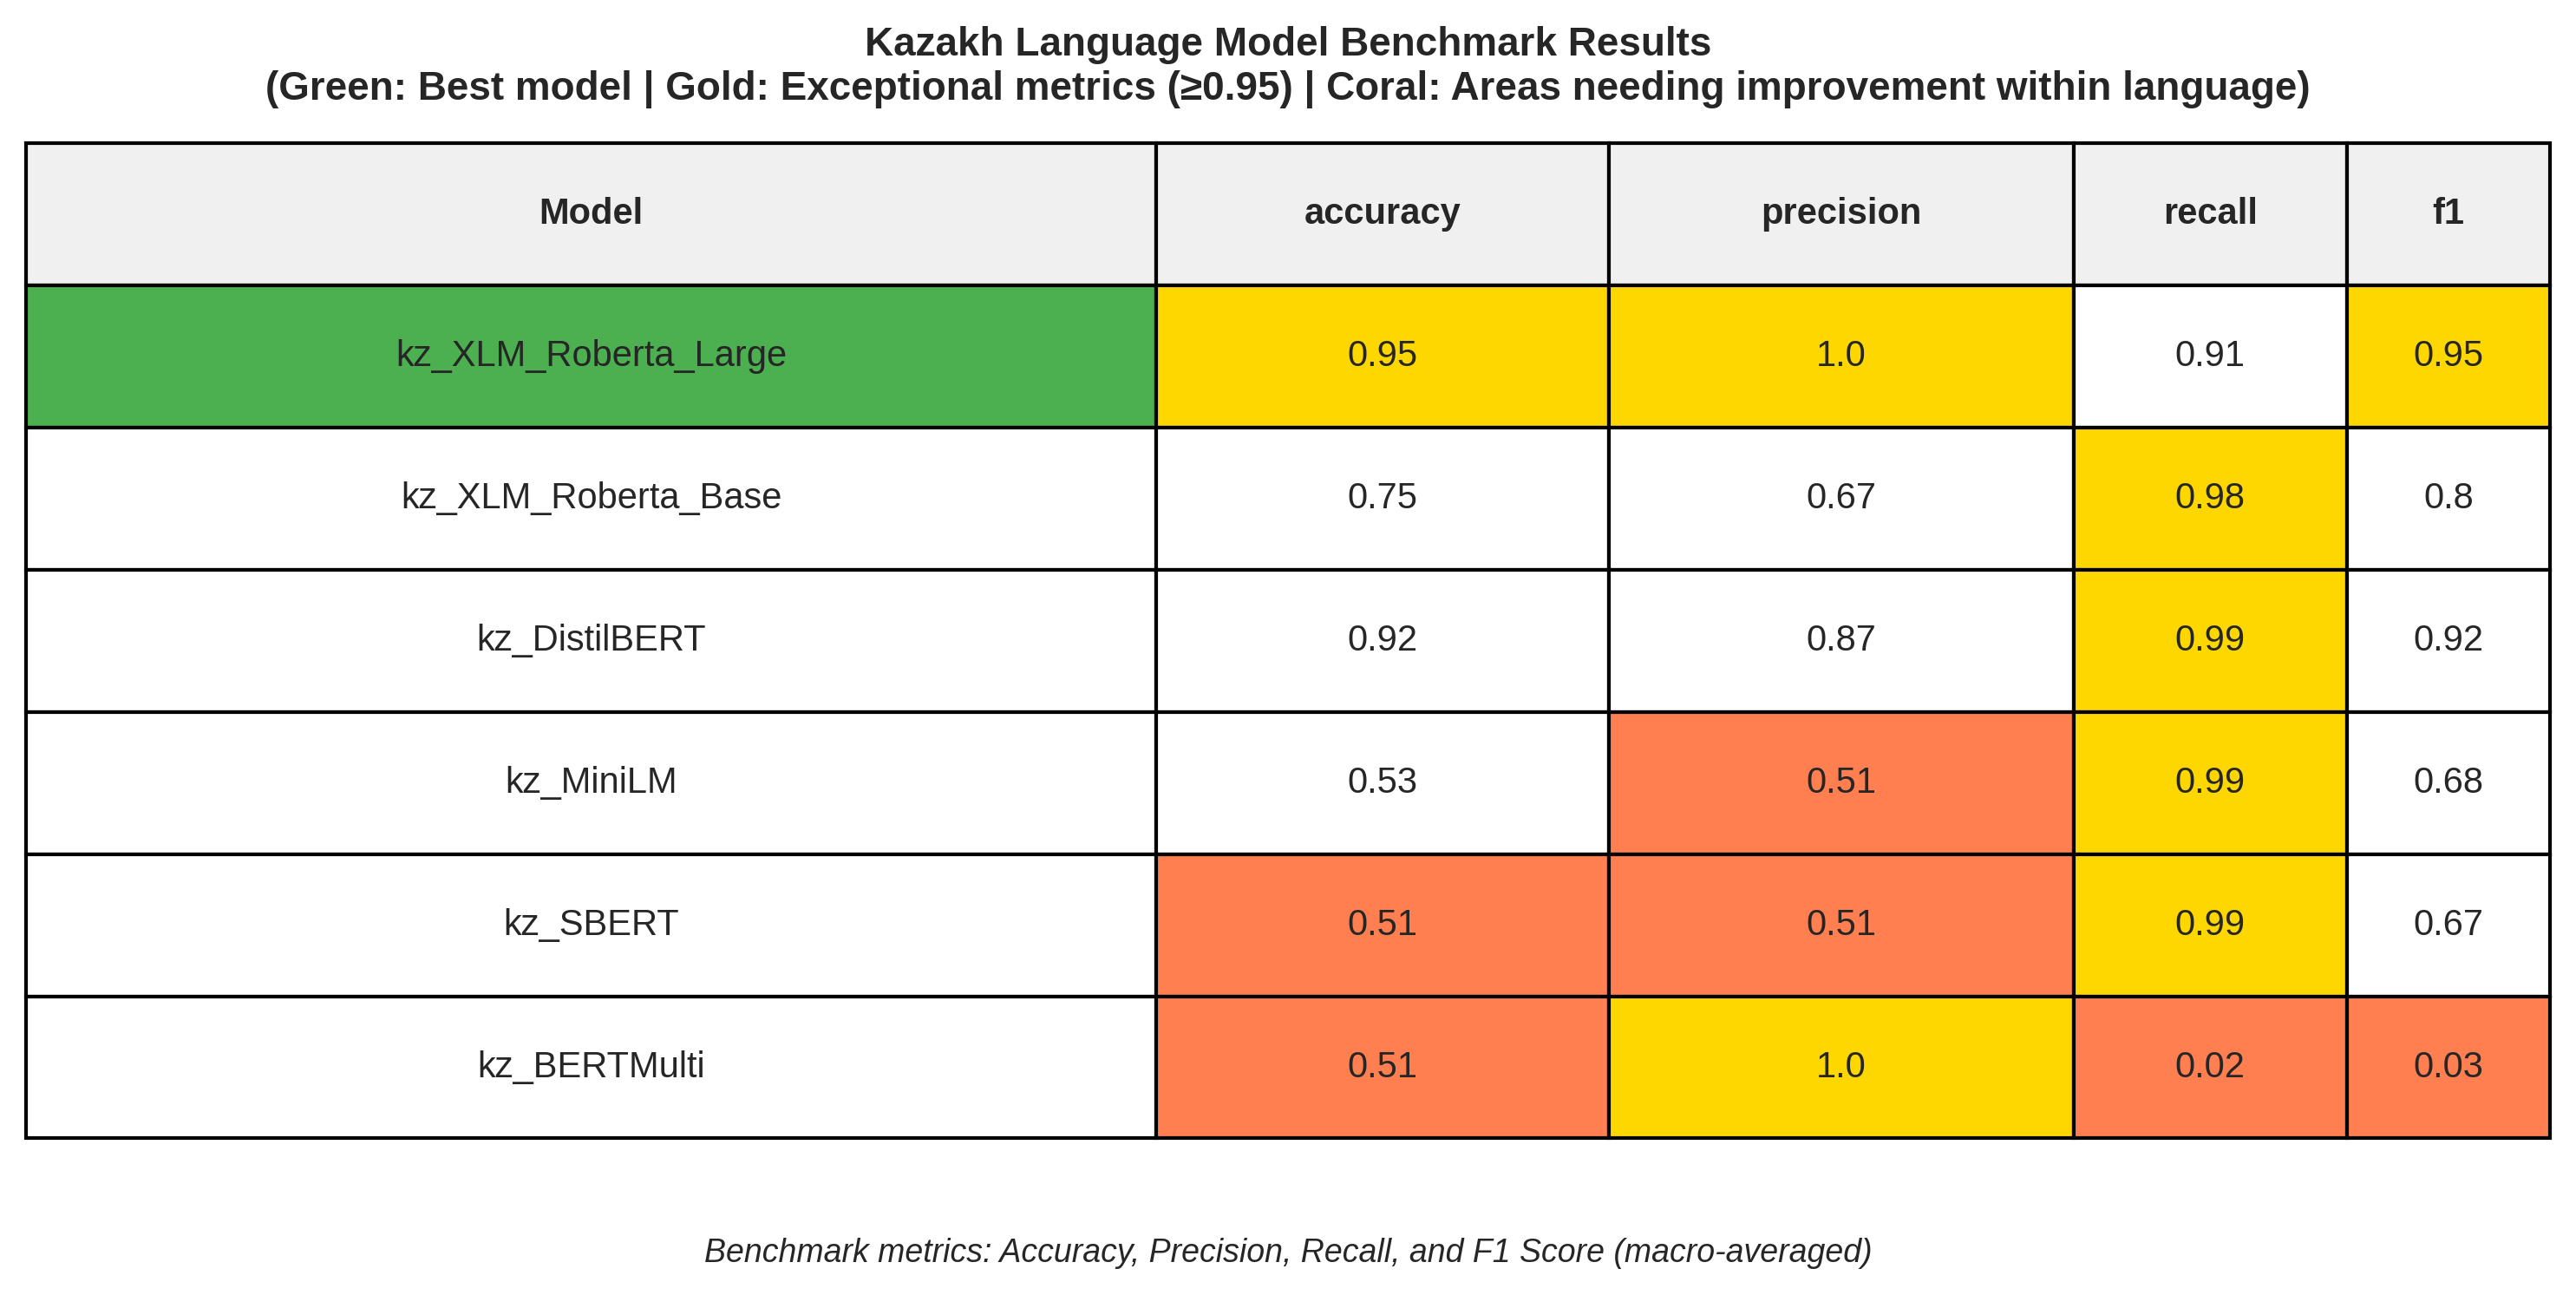

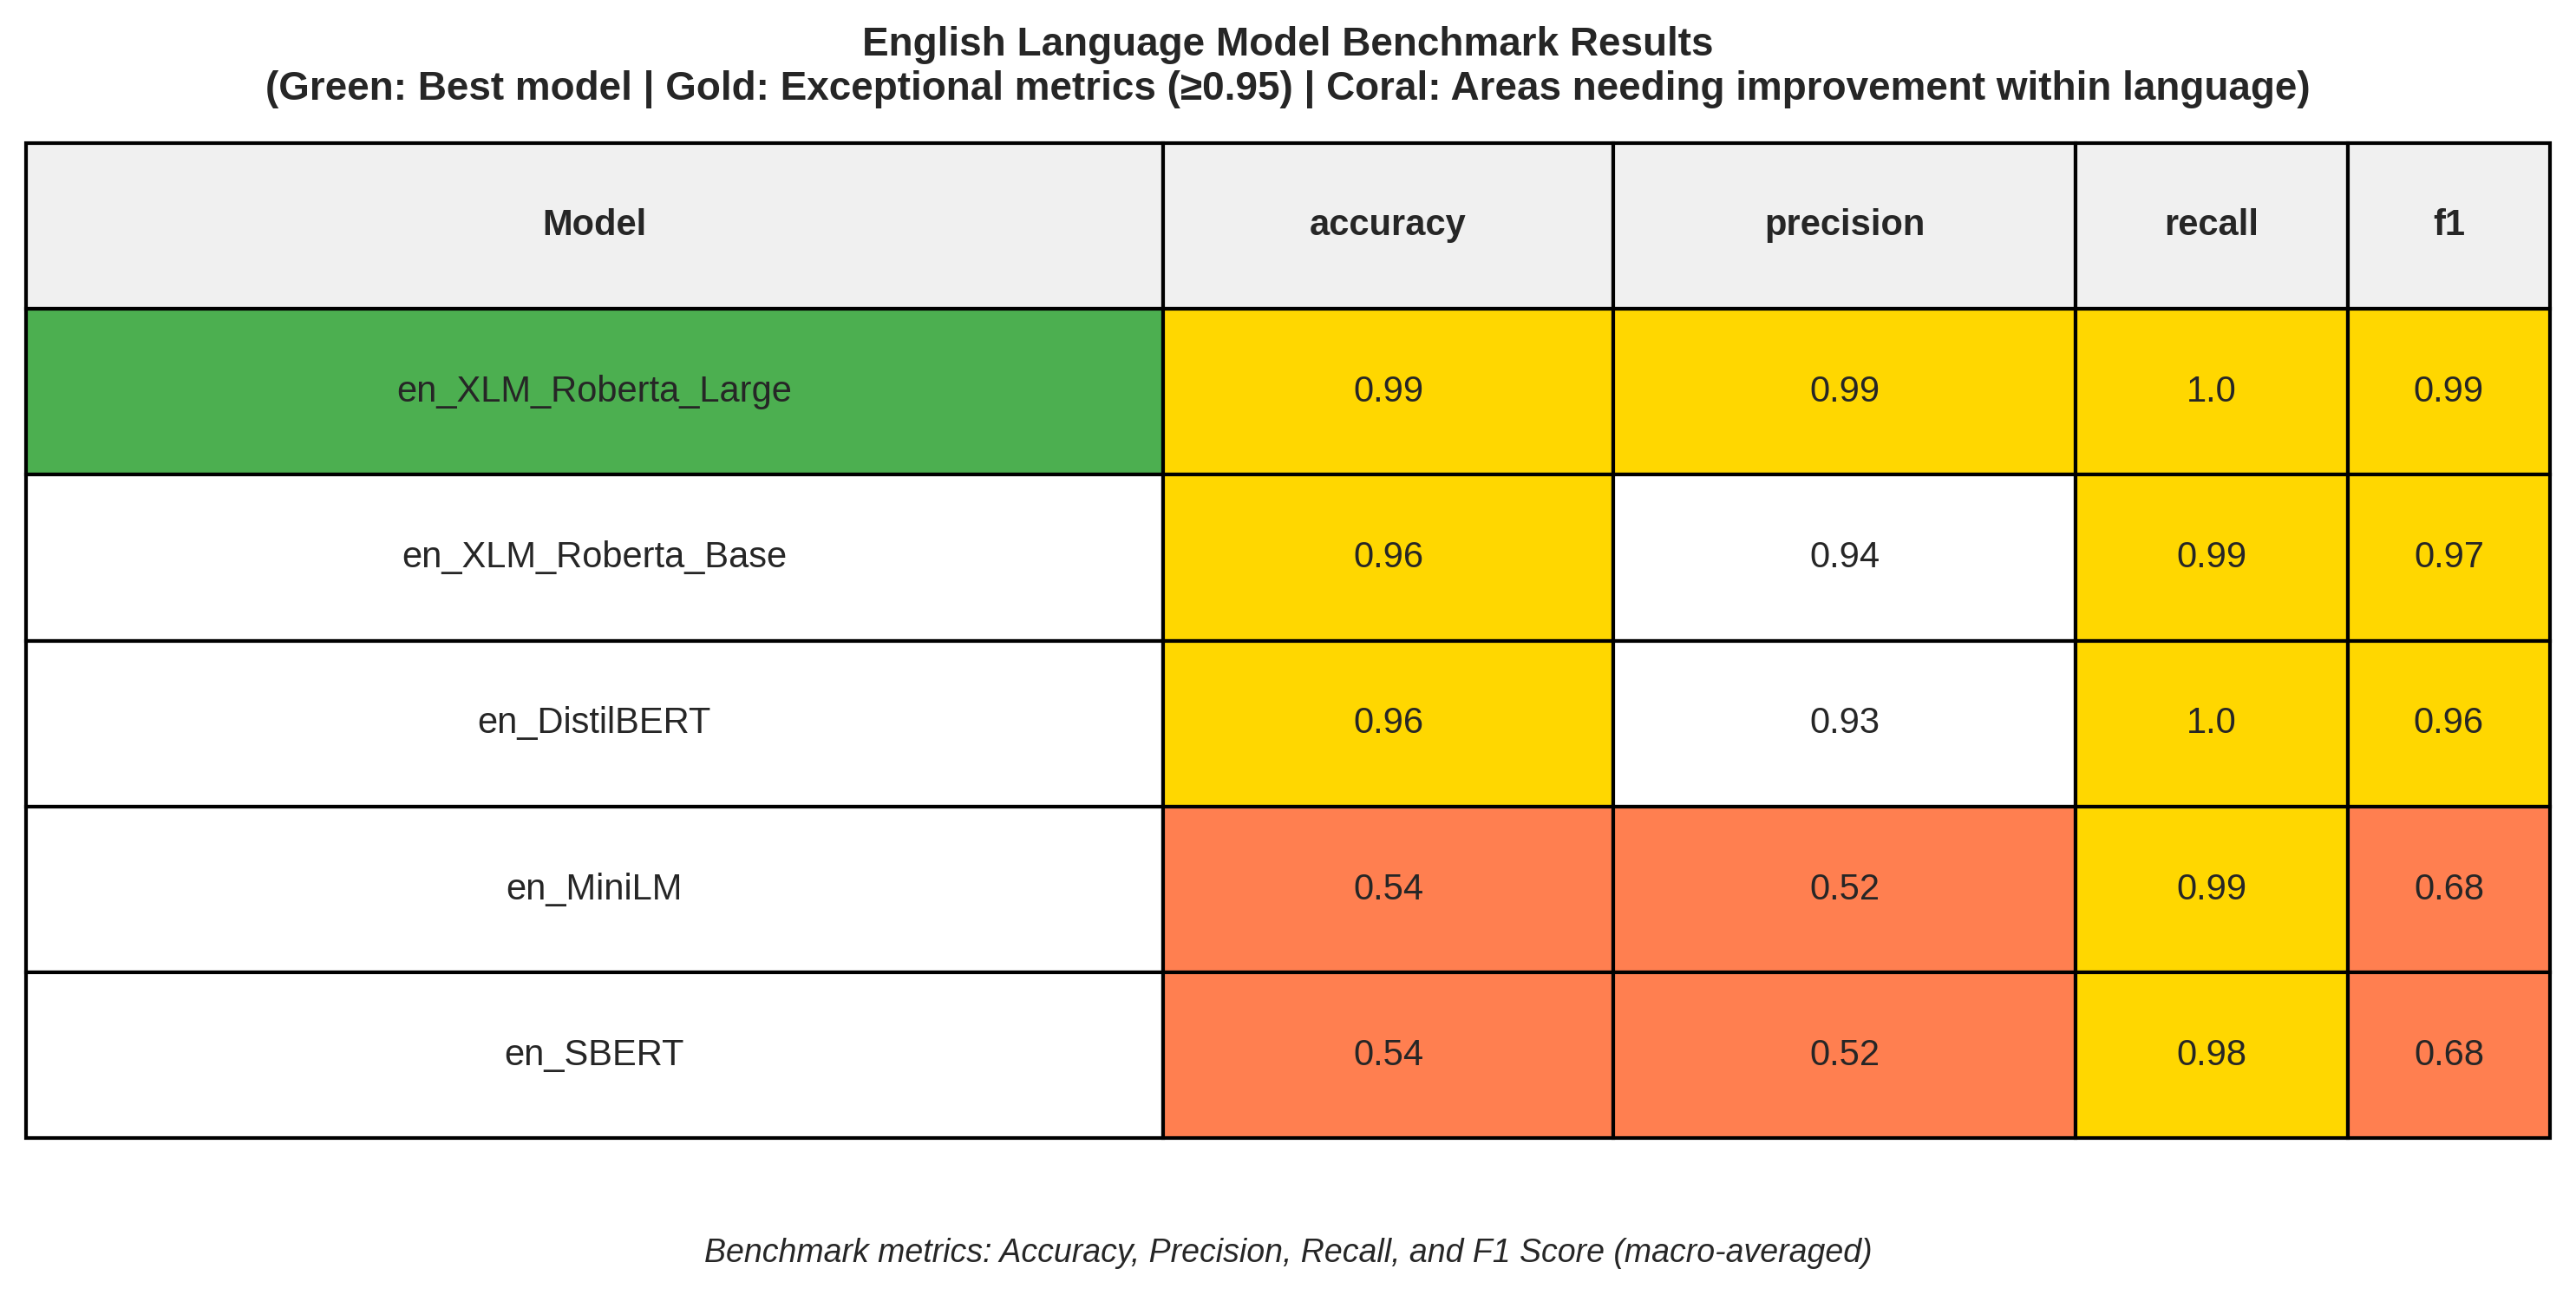

In [47]:
#!pip install seaborn
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np

# Set professional font and style
mpl.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8-whitegrid')

# Load benchmark results
file_path = "/content/drive/MyDrive/updating-pan-xml-files/result/benchmark_results_all_together1.csv"
df_all = pd.read_csv(file_path, index_col=0).round(2)

# Model categorization
df_kz = df_all[df_all.index.str.contains("kz", case=False)]
df_en = df_all[df_all.index.str.contains("en", case=False)]

def create_benchmark_table(df_subset, language):
    """
    Creates publication-quality benchmark table with:
    - Green highlight for best model (by F1 score)
    - Gold highlight for exceptional metrics (≥0.95)
    - Coral highlight for worst metrics within this language group
    """
    # Initialize figure with research paper dimensions
    fig, ax = plt.subplots(figsize=(10, 5), dpi=300)

    # Professional title with metrics explanation
    title = (
        f"{language} Language Model Benchmark Results\n"
        "(Green: Best model | Gold: Exceptional metrics (≥0.95) | "
        "Coral: Areas needing improvement within language)"
    )
    ax.set_title(title, fontsize=11, pad=12, fontweight='semibold')
    ax.axis('off')

    if df_subset.empty:
        print(f"No {language} models found.")
        return fig

    # Prepare table data with model names
    table_data = [[idx] + row.tolist() for idx, row in df_subset.iterrows()]
    columns = ["Model"] + df_subset.columns.tolist()

    # Create table with professional styling
    table = ax.table(
        cellText=table_data,
        colLabels=columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0.1, 1, 0.9]
    )

    # Custom color palette
    best_model_color = '#4CAF50'  # Green
    exceptional_color = '#FFD700'  # Gold
    concern_color = '#FF7F50'     # Coral
    header_color = '#F0F0F0'      # Light gray

    # Style column headers
    for col in range(len(columns)):
        table[0, col].set_facecolor(header_color)
        table[0, col].set_text_props(weight='bold')

    # Highlight single best model by F1 score
    if not df_subset.empty:
        best_model_idx = df_subset['f1'].idxmax()
        best_row_idx = df_subset.index.get_loc(best_model_idx)
        table[best_row_idx+1, 0].set_facecolor(best_model_color)

    # Metric-specific highlighting
    for col_idx, metric in enumerate(df_subset.columns, 1):
        metric_values = df_subset[metric]
        language_min = df_subset[metric].min()

        for row_idx in range(len(df_subset)):
            value = df_subset.iloc[row_idx, col_idx-1]
            cell = table[row_idx+1, col_idx]

            # Highlight exceptional metrics in gold
            if value >= 0.95:
                cell.set_facecolor(exceptional_color)
            # Highlight worst within language in coral
            elif value == language_min:
                cell.set_facecolor(concern_color)

    # Professional typography
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    # Column width adjustment
    for col in range(len(columns)):
        table.auto_set_column_width(col=col)

    # Add methodological footnote
    plt.figtext(
        0.5, 0.02,
        "Benchmark metrics: Accuracy, Precision, Recall, and F1 Score (macro-averaged)",
        ha='center',
        fontsize=9,
        style='italic'
    )

    plt.tight_layout()
    return fig

# Generate publication-ready figures
print("\nGenerating Benchmark Visualizations...")
kz_fig = create_benchmark_table(df_kz, "Kazakh")
en_fig = create_benchmark_table(df_en, "English")

# Display with tight layout
plt.show(kz_fig)
plt.show(en_fig)

# Save publication-quality figures
kz_fig.savefig("kazakh_benchmarks.pdf", bbox_inches='tight', dpi=300)
en_fig.savefig("english_benchmarks.pdf", bbox_inches='tight', dpi=300)

### **Summary**

#### **🏆 Best Kazakh (KZ) Model**
**kz_xlm_roberta_large**  
- **Accuracy**: 0.952  
- **Precision**: 0.997 (near-perfect)  
- **Recall**: 0.907  
- **F1**: 0.950  
✅ **Strengths**: Exceptional precision (minimal false positives) and balanced F1 score.

#### **🏆 Best English (EN) Model**  
**en_xlm_roberta_large**  
- **Accuracy**: 0.992  
- **Precision**: 0.987  
- **Recall**: 0.997 (near-perfect)  
- **F1**: 0.992  
✅ **Strengths**: Near-perfect recall (finds almost all true positives) and outstanding F1 balance.  

---

### **⚠️ Analysis of Underperforming Models**

#### **Kazakh (KZ) Models**
1. **kz_bertmulti**  
   - **Critical Issue**: Recall = 0.016 (fails to detect positives) despite perfect precision (1.000).  
   - **Diagnosis**: Likely overfitted to negative cases or severe class imbalance handling failure.  

2. **kz_minilm** & **kz_sbert**  
   - **Shared Issues**: Low accuracy (~0.51–0.53) and precision (~0.51) but inflated recall (~0.99).  
   - **Diagnosis**: Likely biased toward predicting positives (high false-positive rate).

3. **kz_xlm_roberta_base**  
   - **Moderate Performance**: Decent F1 (0.796) but low precision (0.668).  
   - **Diagnosis**: Trade-off between precision/recall may need rebalancing.  

#### **English (EN) Models**
1. **en_minilm** & **en_sbert**  
   - **Shared Issues**: Poor accuracy (~0.54) and precision (~0.52) despite high recall (~0.98).  
   - **Diagnosis**: Similar to KZ MiniLM/SBERT—biased toward positive predictions.  

**Conclusion:**

After a rigorous benchmark evaluation of multiple models on both Kazakh and English datasets, the **XLM-RoBERTa Large** model emerged as the best-performing solution for our extrinsic plagiarism detection pipeline. Its superior accuracy, near-perfect precision, and balanced F1-score—especially on the challenging Kazakh dataset—demonstrate its robust capability to detect subtle language patterns and handle cross-lingual challenges. Additionally, its proven scalability and efficiency in processing large-scale document comparisons make it the ideal candidate for practical, real-world deployment. For these reasons, we have chosen the XLM-RoBERTa Large model as the backbone of our project.
